<a href="https://colab.research.google.com/github/ZhenghaoXiao32/Frequent-Pattern-Mining-for-PLCB/blob/master/Copy_of_fpm_plcb_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modules and Dependencies

In [1]:
# Install spark-related dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -c http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

!pip install -q findspark
!pip install pyspark

--2020-05-08 16:05:09--  http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving apache.osuosl.org (apache.osuosl.org)... 140.211.166.134, 64.50.236.52, 64.50.233.100, ...
Connecting to apache.osuosl.org (apache.osuosl.org)|140.211.166.134|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232530699 (222M) [application/x-gzip]
Saving to: ‘spark-2.4.5-bin-hadoop2.7.tgz’

spark-2.4.5-bin-had 100%[===================>] 221.76M  54.1MB/s    in 10s     

2020-05-08 16:05:19 (21.7 MB/s) - ‘spark-2.4.5-bin-hadoop2.7.tgz’ saved [232530699/232530699]

     |████████████████████████████████| 217.8MB 14kB/s 
     |████████████████████████████████| 204kB 43.3MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=598ac7991ebacc2a64a933ad0bca1965d3e06c6c20f217a9e194d54cadc9509a
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pysp

In [0]:
# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [3]:
# Point Colaboratory to your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data Preparation

In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pandas as pd

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
# Start SparkSession
app_name = 'PLCB_FPM'
spark_url = 'local[*]'
spark = SparkSession.builder.appName(app_name).master(spark_url).getOrCreate()
sc = spark.sparkContext

## Load data

In [0]:
sales_csv = '/content/gdrive/My Drive/PLCB/sales.csv'
sales_txn = '/content/gdrive/My Drive/PLCB/SalesTransactionFY2018'
txn_item = '/content/gdrive/My Drive/PLCB/txn_item.txt'
product_csv = '/content/gdrive/My Drive/PLCB/product.csv'

In [0]:
# extract the two columns we needed from the text file
if not os.path.exists(txn_item):
  with open('SalesTransactionFY2018', 'r') as fin:
    with open('txn_item.txt', 'w') as fout:
      while True:
        lines = fin.readlines(100000)
        if not lines:
          break
        for line in lines:
          fout.write(line.split('|')[0] + ',' + line.split('|')[3] + '\n')

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [0]:
# read txn_item
# set schema
schema = StructType([StructField("transaction_id", StringType(), True), StructField("item_key", StringType(), True)])

txn_ids = spark.read.csv(txn_item, header=False, schema=schema)

In [0]:
txn_ids.printSchema()

root
 |-- transaction_id: string (nullable = true)
 |-- item_key: string (nullable = true)



In [0]:
txn_ids.show(5)


+--------------+--------+
|transaction_id|item_key|
+--------------+--------+
|   25667401670|  314816|
|   25611070503|  488821|
|   25656710703|    1877|
|   25658029659|  441911|
|   25643984320|  314685|
+--------------+--------+
only showing top 5 rows



In [0]:
# read the product dataset with selected columns
item_class = pd.read_csv(product_csv, 
                         usecols=['ITEM_KEY', 'CLASS_DESC'], 
                         dtype={'ITEM_KEY': 'str', 'CLASS_DESC': 'str'})

In [0]:
# read the product dataset with sub_class and class
item_subclass = pd.read_csv(product_csv, 
                            usecols=['ITEM_KEY', 'SBCLASS_DESC', 'CLASS_DESC'], 
                            dtype={'ITEM_KEY': 'str', 
                                   'SBCLASS_DESC': 'str', 
                                   'CLASS_DESC': 'str'})

In [0]:
item_class.head()

,ITEM_KEY,CLASS_DESC
0,511471,Red Table Wine
1,502792,Red Table Wine
2,33274,Miscellaneous
3,295019,Red Table Wine
4,505118,Red Table Wine


In [0]:
item_class.CLASS_DESC.value_counts()

Red Table Wine           343293
White Table Wine          85094
Sparkling                 17835
Dessert                   12480
Whiskey                   11406
Miscellaneous             10166
Rose Table Wine            8961
Liquor or Cordials         7004
Vodka                      6517
Tequila                    4424
Rum                        3860
Brandy Cognac              3764
Box                        1888
Gin                        1452
Rose or Blush              1146
Cocktails  Mixers          1132
Ready to Drink              884
Supplies                    168
Gift Cards                   94
Bags                         17
Towels                        5
Register Tape                 4
Saleman Sample Spirit         2
Salesman Sample               2
No Class                      1
Name: CLASS_DESC, dtype: int64

Check how many classes we have:

In [0]:
item_class.CLASS_DESC.value_counts().shape[0]

25

In [0]:
item_subclass.head()

,ITEM_KEY,SBCLASS_DESC,CLASS_DESC
0,511471,WA or OR Cabernet Sauvignon,Red Table Wine
1,502792,France Bordeaux,Red Table Wine
2,33274,Hi Proof Flavored,Miscellaneous
3,295019,California Zinfandel,Red Table Wine
4,505118,France Bordeaux,Red Table Wine


In [0]:
item_subclass.SBCLASS_DESC.value_counts()

Imported                  125022
Domestic                   63055
Italy North                19979
France Burgundy            18710
Spain                      16682
                           ...  
Domestic Rose                  4
Salesman Sample Spirit         2
Rose                           2
Salesman Sample                2
No Subclass                    1
Name: SBCLASS_DESC, Length: 158, dtype: int64

Check how many subclasses we have:

In [0]:
item_subclass.SBCLASS_DESC.value_counts().shape[0]

158

Once we look at the subclass descriptions, we will find that it is not informative enough if it is not concatenated with class descriptions. Thus, we decide to concatenate them as a more detailed tag compared to class description.

In [0]:
item_subclass["SUB_DESC"] = item_subclass.SBCLASS_DESC + ' ' + item_subclass.CLASS_DESC

In [0]:
item_subclass.head()

,ITEM_KEY,SBCLASS_DESC,CLASS_DESC,SUB_DESC
0,511471,WA or OR Cabernet Sauvignon,Red Table Wine,WA or OR Cabernet Sauvignon Red Table Wine
1,502792,France Bordeaux,Red Table Wine,France Bordeaux Red Table Wine
2,33274,Hi Proof Flavored,Miscellaneous,Hi Proof Flavored Miscellaneous
3,295019,California Zinfandel,Red Table Wine,California Zinfandel Red Table Wine
4,505118,France Bordeaux,Red Table Wine,France Bordeaux Red Table Wine


Check how many concatenated subclasses we have:

In [0]:
item_subclass.SUB_DESC.value_counts().shape[0]

230

In [0]:
# delete useless columns
item_subclass.drop(columns=["SBCLASS_DESC", "CLASS_DESC"], inplace=True)

In [0]:
item_subclass.head()

,ITEM_KEY,SUB_DESC
0,511471,WA or OR Cabernet Sauvignon Red Table Wine
1,502792,France Bordeaux Red Table Wine
2,33274,Hi Proof Flavored Miscellaneous
3,295019,California Zinfandel Red Table Wine
4,505118,France Bordeaux Red Table Wine


In [0]:
# change item_class to spark dataframe
schema = StructType([StructField("item_key", StringType(), True), StructField("class_desc", StringType(), True)])

df_class = spark.createDataFrame(item_class, schema=schema)

In [0]:
df_class.show(5)

+--------+--------------+
|item_key|    class_desc|
+--------+--------------+
|  511471|Red Table Wine|
|  502792|Red Table Wine|
|   33274| Miscellaneous|
|  295019|Red Table Wine|
|  505118|Red Table Wine|
+--------+--------------+
only showing top 5 rows



In [0]:
# change item_subclass to spark dataframe
schema = StructType([StructField("item_key", StringType(), True), StructField("sub_desc", StringType(), True)])

df_subclass = spark.createDataFrame(item_subclass, schema=schema)

## Join data

In [0]:
# join the df_class and df_txn to get the class of each item listed in dataset
txn_class = txn_ids.join(df_class, "item_key", "left")

In [0]:
txn_class.show(5)

+--------+--------------+----------+
|item_key|transaction_id|class_desc|
+--------+--------------+----------+
|  133979|   25617003530|       Gin|
|  133979|   25598982888|       Gin|
|  133979|   25611892972|       Gin|
|  133979|   25582882489|       Gin|
|  133979|   25619140916|       Gin|
+--------+--------------+----------+
only showing top 5 rows



In [0]:
txn_class.select(["transaction_id", "class_desc"]).show(5)

+--------------+----------+
|transaction_id|class_desc|
+--------------+----------+
|   25617003530|       Gin|
|   25598982888|       Gin|
|   25611892972|       Gin|
|   25582882489|       Gin|
|   25619140916|       Gin|
+--------------+----------+
only showing top 5 rows



In [0]:
# join the df_class and df_txn to get the class of each item listed in dataset
txn_subclass = txn_ids.join(df_subclass, "item_key", "left")

In [0]:
txn_subclass.show(5)

+--------+--------------+--------------+
|item_key|transaction_id|      sub_desc|
+--------+--------------+--------------+
|  133979|   25617003530|Unflavored Gin|
|  133979|   25598982888|Unflavored Gin|
|  133979|   25611892972|Unflavored Gin|
|  133979|   25582882489|Unflavored Gin|
|  133979|   25619140916|Unflavored Gin|
+--------+--------------+--------------+
only showing top 5 rows



## Collect to list

In [0]:
# for class 
# group by transaction_id and gather the items to a list
from pyspark.sql import functions as F
df_txn = txn_class.select(["transaction_id", "class_desc"]).\
groupby("transaction_id").agg(F.collect_set("class_desc").alias("item_list_by_class"))

In [0]:
df_txn.show(5)

+--------------------+--------------------+
|      transaction_id|  item_list_by_class|
+--------------------+--------------------+
|10000000000000012...|[Red Table Wine, ...|
|10000000000000012...|[Red Table Wine, ...|
|10000000000000012...|[Whiskey, Dessert...|
|10000000000000012...|[Red Table Wine, ...|
|10000000000000012...|[Red Table Wine, ...|
+--------------------+--------------------+
only showing top 5 rows



In [0]:
df_txn.count()

66841392

In [0]:
# for subclass 
# group by transaction_id and gather the items to a list
from pyspark.sql import functions as F
df_subtxn = txn_subclass.select(["transaction_id", "sub_desc"]).\
groupby("transaction_id").agg(F.collect_set("sub_desc").alias("item_list_by_subclass"))

In [0]:
df_subtxn.count()

66841392

We have 66m transactions

# Frequent Pattern Mining

## For Class

In [0]:
from pyspark.ml.fpm import FPGrowth

In [0]:
fpGrowth = FPGrowth(itemsCol="item_list_by_class", minSupport=0.003, minConfidence=0.5)
model = fpGrowth.fit(df_txn)

In [0]:
model.freqItemsets.show()

+--------------------+--------+
|               items|    freq|
+--------------------+--------+
|             [Vodka]|18306576|
|           [Whiskey]|14148619|
|    [Whiskey, Vodka]| 2299482|
|    [Red Table Wine]|12113437|
|[Red Table Wine, ...| 1439321|
|[Red Table Wine, ...|  390627|
|[Red Table Wine, ...| 1340190|
|  [White Table Wine]|10552459|
|[White Table Wine...| 3239763|
|[White Table Wine...|  490911|
|[White Table Wine...|  224245|
|[White Table Wine...|  490061|
|[White Table Wine...| 1186360|
|[White Table Wine...|  390164|
|[White Table Wine...| 1346485|
|               [Rum]| 6376457|
|[Rum, Red Table W...|  520904|
|[Rum, Red Table W...|  228710|
|[Rum, Red Table W...|  237393|
|      [Rum, Whiskey]| 1174363|
+--------------------+--------+
only showing top 20 rows



In [0]:
model.freqItemsets.sort(desc("freq")).show(15, False)

+----------------------------------+--------+
|items                             |freq    |
+----------------------------------+--------+
|[Vodka]                           |18306576|
|[Whiskey]                         |14148619|
|[Red Table Wine]                  |12113437|
|[White Table Wine]                |10552459|
|[Rum]                             |6376457 |
|[Brandy Cognac]                   |5269276 |
|[Liquor or Cordials]              |5163085 |
|[Miscellaneous]                   |5080780 |
|[Box]                             |5001738 |
|[White Table Wine, Red Table Wine]|3239763 |
|[Sparkling]                       |2963891 |
|[Rose or Blush]                   |2824125 |
|[Tequila]                         |2466084 |
|[Whiskey, Vodka]                  |2299482 |
|[Gin]                             |1991428 |
+----------------------------------+--------+
only showing top 15 rows



In [0]:
freq_byclass = model.freqItemsets.sort(desc("freq")).limit(15).toPandas()

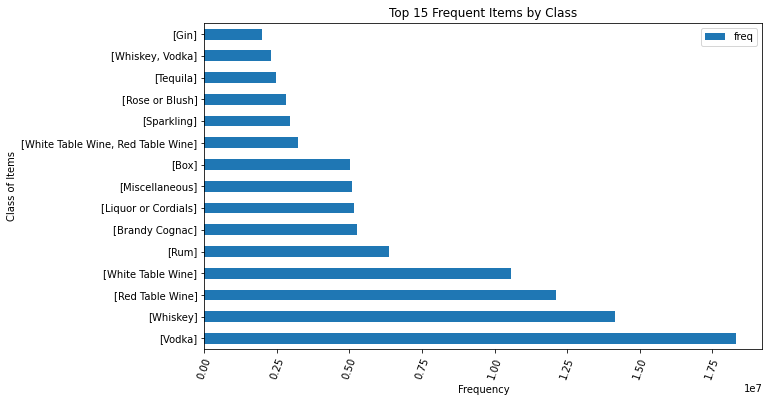

In [25]:
freq_byclass.plot(x="items", kind="barh", figsize=(10,6))
plt.title("Top 15 Frequent Items by Class")
plt.xticks(rotation=70)
plt.ylabel("Class of Items")
plt.xlabel("Frequency")
plt.show()

In [0]:
model.freqItemsets.count()

126

In [0]:
model.associationRules.show()

+--------------------+--------------------+------------------+------------------+
|          antecedent|          consequent|        confidence|              lift|
+--------------------+--------------------+------------------+------------------+
|[Tequila, Rum, Wh...|             [Vodka]|0.8794699430469171|3.2111409154511827|
|[Tequila, Rum, Wh...|[Liquor or Cordials]|0.7850276025810963|10.162981573021415|
|[Tequila, Liquor ...|           [Whiskey]|0.9171705122835133| 4.332928446400538|
|[Liquor or Cordia...|             [Vodka]|0.7945844032408504| 2.901204877094862|
|[White Table Wine...|    [Red Table Wine]|0.5747454916394131|  3.17141936734411|
|[White Table Wine...|[Liquor or Cordials]|0.5182359213048872| 6.709091631150972|
|[Rum, Whiskey, Vo...|[Liquor or Cordials]|0.6377436798389664| 8.256241239421557|
|[Liquor or Cordia...|           [Tequila]| 0.561698722417091|15.224430510469215|
|      [Tequila, Rum]|           [Whiskey]|0.6799245331603472|3.2121228404968543|
|      [Tequila,

In [0]:
model.associationRules.count()

48

In [0]:
model.associationRules.filter("confidence>0.6").count()

37

In [0]:
model.associationRules.filter("confidence>0.7").count()

28

In [0]:
model.associationRules.filter("confidence>0.8").count()

14

In [0]:
model.associationRules.filter("confidence>0.9").count()

2

In [0]:
model.associationRules.filter("confidence>0.8").show(20, False)

+---------------------------------------------+--------------------+------------------+------------------+
|antecedent                                   |consequent          |confidence        |lift              |
+---------------------------------------------+--------------------+------------------+------------------+
|[Tequila, Rum, Whiskey]                      |[Vodka]             |0.8794699430469171|3.2111409154511827|
|[Tequila, Liquor or Cordials, Rum, Vodka]    |[Whiskey]           |0.9171705122835133|4.332928446400538 |
|[Gin, Rum, Vodka]                            |[Whiskey]           |0.8480266378568173|4.006276579179181 |
|[Tequila, Liquor or Cordials, Vodka]         |[Whiskey]           |0.8397760060095949|3.967298660730188 |
|[Gin, Liquor or Cordials, Whiskey]           |[Vodka]             |0.8761172917715258|3.198899637883071 |
|[Tequila, Liquor or Cordials, Rum]           |[Whiskey]           |0.8728136943706679|4.123376443199015 |
|[Tequila, Liquor or Cordials, Rum]  

In [0]:
model.associationRules.filter("confidence>0.7").show(40, False)


+-----------------------------------------------+--------------------+------------------+------------------+
|antecedent                                     |consequent          |confidence        |lift              |
+-----------------------------------------------+--------------------+------------------+------------------+
|[Tequila, Rum, Whiskey]                        |[Vodka]             |0.8794699430469171|3.2111409154511827|
|[Tequila, Rum, Whiskey]                        |[Liquor or Cordials]|0.7850276025810963|10.162981573021415|
|[Tequila, Liquor or Cordials, Rum, Vodka]      |[Whiskey]           |0.9171705122835133|4.332928446400538 |
|[Liquor or Cordials, Rum, Whiskey]             |[Vodka]             |0.7945844032408504|2.901204877094862 |
|[Tequila, Rum]                                 |[Vodka]             |0.7145902556662028|2.609128402731613 |
|[Gin, Rum, Vodka]                              |[Whiskey]           |0.8480266378568173|4.006276579179181 |
|[Tequila, Liquor o

In [0]:
model.associationRules.filter("confidence>0.7").sort(desc("confidence")).show(40, False)


+-----------------------------------------------+--------------------+------------------+------------------+
|antecedent                                     |consequent          |confidence        |lift              |
+-----------------------------------------------+--------------------+------------------+------------------+
|[Tequila, Liquor or Cordials, Rum, Whiskey]    |[Vodka]             |0.9344691944447021|3.41195544911307  |
|[Tequila, Liquor or Cordials, Rum, Vodka]      |[Whiskey]           |0.9171705122835133|4.332928446400538 |
|[Gin, Rum, Whiskey]                            |[Vodka]             |0.8989178718892731|3.282149641241305 |
|[Tequila, Liquor or Cordials, Rum]             |[Vodka]             |0.8892757660167131|3.246944162164645 |
|[Tequila, Rum, Whiskey]                        |[Vodka]             |0.8794699430469171|3.2111409154511827|
|[Gin, Liquor or Cordials, Whiskey]             |[Vodka]             |0.8761172917715258|3.198899637883071 |
|[Tequila, Liquor o

## For Subclass

In [0]:
# adjust the min-support and min-confidence for subclass
# we have 230 concatenated subclasses while only 25 classes
# so we decrease both min-support and min-confidence
fpGrowth = FPGrowth(itemsCol="item_list_by_subclass", minSupport=0.0025, minConfidence=0.3)
submodel = fpGrowth.fit(df_subtxn)

In [0]:
submodel.freqItemsets.sort(desc("freq")).show(20, False)

+----------------------------------------------+--------+
|items                                         |freq    |
+----------------------------------------------+--------+
|[Unflavored Vodka]                            |14637097|
|[American Whiskey]                            |6592636 |
|[Flavored Vodka]                              |4361207 |
|[Canadian Whiskey]                            |3188793 |
|[Flavored Whiskey]                            |2987665 |
|[California Cabernet Sauvignon Red Table Wine]|2914326 |
|[California Chardonnay White Table Wine]      |2717021 |
|[Unflavored Rum]                              |2526872 |
|[Flavored Rum]                                |2256568 |
|[Red Box]                                     |2248743 |
|[California Red Blend Red Table Wine]         |2242968 |
|[Brandy Brandy Cognac]                        |2223916 |
|[Beverage Miscellaneous]                      |2160243 |
|[Spiced Rum]                                  |2064565 |
|[Unflavored G

In [0]:
freq_bysubclass = submodel.freqItemsets.sort(desc("freq")).limit(15).toPandas()

In [0]:
freq_bysubclass

,items,freq
0,[Unflavored Vodka],14637097
1,[American Whiskey],6592636
2,[Flavored Vodka],4361207
3,[Canadian Whiskey],3188793
4,[Flavored Whiskey],2987665
5,[California Cabernet Sauvignon Red Table Wine],2914326
6,[California Chardonnay White Table Wine],2717021
7,[Unflavored Rum],2526872
8,[Flavored Rum],2256568
9,[Red Box],2248743


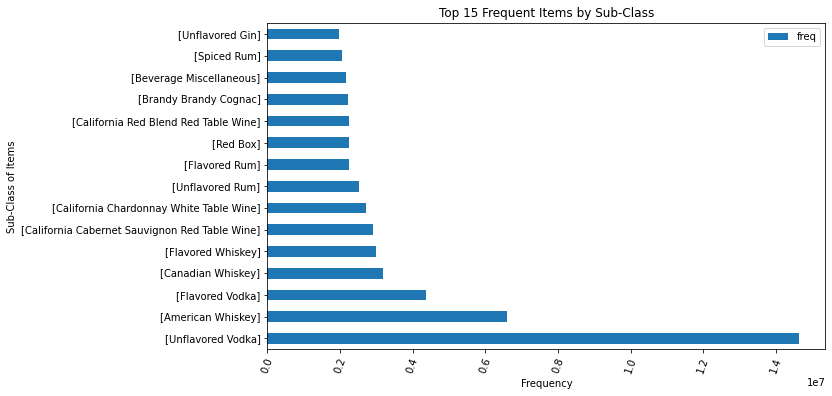

In [28]:
freq_bysubclass.plot(x="items", kind="barh", figsize=(10,6))
plt.title("Top 15 Frequent Items by Sub-Class")
plt.xticks(rotation=70)
plt.ylabel("Sub-Class of Items")
plt.xlabel("Frequency")
plt.show()

In [0]:
submodel.associationRules.show()

+--------------------+--------------------+-------------------+------------------+
|          antecedent|          consequent|         confidence|              lift|
+--------------------+--------------------+-------------------+------------------+
|[Flavored Whiskey...|  [American Whiskey]| 0.3509225848477973|3.5579325258462444|
|[Schnapps Liquor ...|  [Unflavored Vodka]| 0.6596959158451413| 3.012550460778124|
|[Schnapps Liquor ...|  [Canadian Whiskey]| 0.4861035265714368|10.189383999570943|
|[Non Alcohol Cock...|  [Unflavored Vodka]| 0.3408082269448083|1.5563261139857782|
|[Flavored Whiskey...|  [Unflavored Vodka]|0.49040074461991656| 2.239451471028151|
|[Flavored Rum, Un...|  [American Whiskey]|0.47919987998708335| 4.858509862302362|
|[Unflavored Gin, ...|  [Unflavored Vodka]| 0.6469781656672575|2.9544739087816456|
|[Spiced Rum, Amer...|  [Unflavored Vodka]|  0.639350362584034|2.9196409787283333|
|[Canadian Whiskey...|    [Flavored Vodka]|0.31282978138645146|4.7945392289166975|
|[Ca

In [0]:
submodel.associationRules.count()

30

In [0]:
submodel.associationRules.filter("confidence>0.6").count()

11

In [0]:
submodel.associationRules.filter("confidence>0.5").sort(desc("confidence")).show(20, False)

+-----------------------------------------------+------------------+------------------+------------------+
|antecedent                                     |consequent        |confidence        |lift              |
+-----------------------------------------------+------------------+------------------+------------------+
|[Schnapps Liquor or Cordials, Canadian Whiskey]|[Unflavored Vodka]|0.6975570097164386|3.1854459616414568|
|[Unflavored Rum, American Whiskey]             |[Unflavored Vodka]|0.689831822822634 |3.1501683211747675|
|[Schnapps Liquor or Cordials, Canadian Whiskey]|[American Whiskey]|0.6707515367836605|6.800613048370799 |
|[Irish Whiskey, American Whiskey]              |[Unflavored Vodka]|0.664329653661414 |3.033710769123605 |
|[Schnapps Liquor or Cordials, American Whiskey]|[Unflavored Vodka]|0.6596959158451413|3.012550460778124 |
|[Unflavored Gin, American Whiskey]             |[Unflavored Vodka]|0.6469781656672575|2.9544739087816456|
|[Canadian Whiskey, Flavored Vodka]  